In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])


val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dir = os.path.join('/content/drive/MyDrive/the_wildfire_dataset_2n_version/train')
val_dir = os.path.join('/content/drive/MyDrive/the_wildfire_dataset_2n_version/val')
test_dir = os.path.join('/content/drive/MyDrive/the_wildfire_dataset_2n_version/test')

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size ,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=4)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4)



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


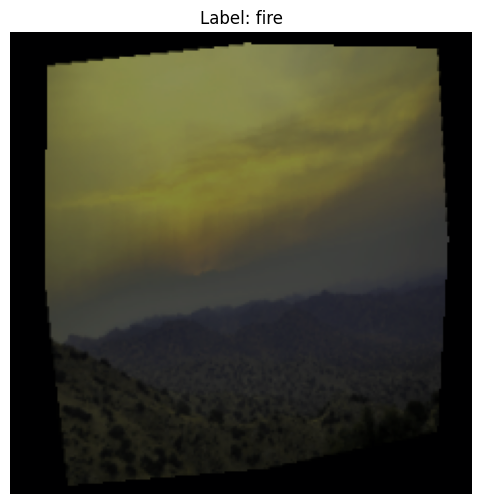

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random


index = random.randint(0, len(train_dataset) - 1)
image, label = train_dataset[index]


image = image.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean
image = np.clip(image, 0, 1)

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"Label: {train_dataset.classes[label]}")
plt.axis('off')
plt.show()

In [ ]:
model = nn.Sequential(
    nn.AdaptiveAvgPool2d((224, 224)),


    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(512, 512, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
summary(model, input_size=(3,224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool2d-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 64, 224, 224]           1,792
       BatchNorm2d-3         [-1, 64, 224, 224]             128
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
       BatchNorm2d-7        [-1, 128, 112, 112]             256
              ReLU-8        [-1, 128, 112, 112]               0
         MaxPool2d-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 256, 56, 56]         295,168
      BatchNorm2d-11          [-1, 256, 56, 56]             512
             ReLU-12          [-1, 256, 56, 56]               0
        MaxPool2d-13          [-1, 256, 28, 28]               0
           Conv2d-14          [-1, 512,

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:


import torch
from tqdm import tqdm

def train_model(model, criterion, optimizer, num_epochs=10):
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)


        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device).float()


                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                running_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs).squeeze() > 0.5
                running_corrects += torch.sum(preds == labels.byte())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')

        print()

    print(f'Best val Acc: {best_val_accuracy:.4f}')


    torch.save(model.state_dict(), 'last_model.pth')

    return model




def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs)
            preds = torch.sigmoid(outputs).squeeze() > 0.5
            correct += (preds == labels.byte()).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return accuracy



In [ ]:
num_epochs = 50
trained_model = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/50
----------


train:   7%|▋         | 4/59 [01:16<11:31, 12.58s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  37%|███▋      | 22/59 [03:48<03:50,  6.23s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [09:08<00:00,  9.30s/it]


train Loss: 4.4938 Acc: 0.5941


val: 100%|██████████| 13/13 [01:56<00:00,  8.99s/it]


val Loss: 0.8234 Acc: 0.6592

Epoch 2/50
----------


train:   0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  49%|████▉     | 29/59 [04:02<02:15,  4.51s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:49<00:00,  7.96s/it]


train Loss: 1.2406 Acc: 0.6068


val: 100%|██████████| 13/13 [01:46<00:00,  8.17s/it]


val Loss: 0.7215 Acc: 0.6841

Epoch 3/50
----------


train:  25%|██▌       | 15/59 [02:08<04:00,  5.48s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  61%|██████    | 36/59 [04:58<02:22,  6.19s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:53<00:00,  8.02s/it]


train Loss: 0.7763 Acc: 0.6396


val: 100%|██████████| 13/13 [01:46<00:00,  8.23s/it]


val Loss: 0.5450 Acc: 0.7065

Epoch 4/50
----------


train:  34%|███▍      | 20/59 [02:49<03:25,  5.27s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  88%|████████▊ | 52/59 [07:13<00:30,  4.40s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:59<00:00,  8.13s/it]


train Loss: 0.6131 Acc: 0.6815


val: 100%|██████████| 13/13 [01:46<00:00,  8.17s/it]


val Loss: 0.5772 Acc: 0.7040

Epoch 5/50
----------


train:  27%|██▋       | 16/59 [02:11<03:34,  4.98s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  81%|████████▏ | 48/59 [06:51<01:00,  5.51s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:06<00:00,  8.25s/it]


train Loss: 0.5800 Acc: 0.6857


val: 100%|██████████| 13/13 [01:47<00:00,  8.30s/it]


val Loss: 0.5295 Acc: 0.6965

Epoch 6/50
----------


train:  20%|██        | 12/59 [01:41<04:08,  5.30s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  56%|█████▌    | 33/59 [04:35<02:35,  5.99s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:05<00:00,  8.23s/it]


train Loss: 0.5401 Acc: 0.7160


val: 100%|██████████| 13/13 [01:46<00:00,  8.15s/it]


val Loss: 0.5182 Acc: 0.7090

Epoch 7/50
----------


train:  27%|██▋       | 16/59 [02:25<03:35,  5.02s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  88%|████████▊ | 52/59 [07:37<00:31,  4.54s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:17<00:00,  8.44s/it]


train Loss: 0.5353 Acc: 0.7186


val: 100%|██████████| 13/13 [01:45<00:00,  8.15s/it]


val Loss: 0.5088 Acc: 0.6891

Epoch 8/50
----------


train:  14%|█▎        | 8/59 [01:06<03:53,  4.58s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  34%|███▍      | 20/59 [02:51<03:55,  6.04s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:06<00:00,  8.25s/it]


train Loss: 0.5323 Acc: 0.7393


val: 100%|██████████| 13/13 [01:46<00:00,  8.18s/it]


val Loss: 0.5149 Acc: 0.7214

Epoch 9/50
----------


train:  20%|██        | 12/59 [01:46<03:46,  4.82s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  81%|████████▏ | 48/59 [06:43<00:57,  5.19s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:08<00:00,  8.28s/it]


train Loss: 0.5144 Acc: 0.7345


val: 100%|██████████| 13/13 [01:46<00:00,  8.23s/it]


val Loss: 0.5143 Acc: 0.7413

Epoch 10/50
----------


train:  68%|██████▊   | 40/59 [05:36<01:48,  5.72s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  75%|███████▍  | 44/59 [06:09<01:33,  6.24s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:09<00:00,  8.30s/it]


train Loss: 0.5072 Acc: 0.7398


val: 100%|██████████| 13/13 [01:47<00:00,  8.24s/it]


val Loss: 0.4751 Acc: 0.7413

Epoch 11/50
----------


train:   7%|▋         | 4/59 [00:36<04:59,  5.45s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  81%|████████▏ | 48/59 [06:47<00:53,  4.87s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:01<00:00,  8.16s/it]


train Loss: 0.4916 Acc: 0.7515


val: 100%|██████████| 13/13 [01:46<00:00,  8.16s/it]


val Loss: 0.4510 Acc: 0.7711

Epoch 12/50
----------


train:  14%|█▎        | 8/59 [01:07<04:09,  4.89s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  68%|██████▊   | 40/59 [05:41<01:28,  4.63s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:04<00:00,  8.21s/it]


train Loss: 0.4828 Acc: 0.7599


val: 100%|██████████| 13/13 [01:45<00:00,  8.10s/it]


val Loss: 0.5005 Acc: 0.7537

Epoch 13/50
----------


train:  14%|█▎        | 8/59 [01:09<04:26,  5.23s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  34%|███▍      | 20/59 [02:51<02:41,  4.14s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:56<00:00,  8.07s/it]


train Loss: 0.4760 Acc: 0.7594


val: 100%|██████████| 13/13 [01:44<00:00,  8.07s/it]


val Loss: 0.5123 Acc: 0.7313

Epoch 14/50
----------


train:   0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  14%|█▎        | 8/59 [01:07<03:49,  4.50s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:08<00:00,  8.27s/it]


train Loss: 0.4899 Acc: 0.7536


val: 100%|██████████| 13/13 [01:47<00:00,  8.24s/it]


val Loss: 0.4632 Acc: 0.7512

Epoch 15/50
----------


train:   0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:02<00:00,  8.18s/it]


train Loss: 0.4746 Acc: 0.7679


val: 100%|██████████| 13/13 [01:45<00:00,  8.15s/it]


val Loss: 0.4849 Acc: 0.7687

Epoch 16/50
----------


train:  47%|████▋     | 28/59 [03:56<02:27,  4.76s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  76%|███████▋  | 45/59 [06:28<02:19, 10.00s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:49<00:00,  7.95s/it]


train Loss: 0.4731 Acc: 0.7674


val: 100%|██████████| 13/13 [01:46<00:00,  8.16s/it]


val Loss: 0.4621 Acc: 0.7935

Epoch 17/50
----------


train:   2%|▏         | 1/59 [00:26<25:23, 26.27s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:   7%|▋         | 4/59 [00:34<04:47,  5.23s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:08<00:00,  8.28s/it]


train Loss: 0.4854 Acc: 0.7599


val: 100%|██████████| 13/13 [01:47<00:00,  8.26s/it]


val Loss: 0.4622 Acc: 0.7512

Epoch 18/50
----------


train:  58%|█████▊    | 34/59 [04:50<03:08,  7.53s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  71%|███████   | 42/59 [06:03<02:52, 10.12s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:03<00:00,  8.19s/it]


train Loss: 0.4988 Acc: 0.7636


val: 100%|██████████| 13/13 [01:45<00:00,  8.12s/it]


val Loss: 0.4528 Acc: 0.7711

Epoch 19/50
----------


train:  58%|█████▊    | 34/59 [04:36<01:54,  4.59s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  81%|████████▏ | 48/59 [06:29<01:04,  5.87s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:55<00:00,  8.06s/it]


train Loss: 0.4782 Acc: 0.7605


val: 100%|██████████| 13/13 [01:43<00:00,  7.99s/it]


val Loss: 0.4474 Acc: 0.7637

Epoch 20/50
----------


train:  20%|██        | 12/59 [01:45<03:58,  5.07s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  61%|██████    | 36/59 [05:03<01:35,  4.14s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:09<00:00,  8.30s/it]


train Loss: 0.4635 Acc: 0.7827


val: 100%|██████████| 13/13 [01:44<00:00,  8.04s/it]


val Loss: 0.4714 Acc: 0.7687

Epoch 21/50
----------


train:  20%|██        | 12/59 [01:38<03:30,  4.47s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  81%|████████▏ | 48/59 [06:48<00:49,  4.48s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:59<00:00,  8.13s/it]


train Loss: 0.4468 Acc: 0.7838


val: 100%|██████████| 13/13 [01:47<00:00,  8.29s/it]


val Loss: 0.4623 Acc: 0.7637

Epoch 22/50
----------


train:  34%|███▍      | 20/59 [02:56<04:10,  6.41s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  64%|██████▍   | 38/59 [05:25<02:33,  7.32s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:00<00:00,  8.15s/it]


train Loss: 0.4571 Acc: 0.7737


val: 100%|██████████| 13/13 [01:45<00:00,  8.15s/it]


val Loss: 0.4284 Acc: 0.7960

Epoch 23/50
----------


train:  41%|████      | 24/59 [03:26<02:56,  5.05s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  54%|█████▍    | 32/59 [04:25<01:47,  3.99s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:02<00:00,  8.17s/it]


train Loss: 0.4523 Acc: 0.7758


val: 100%|██████████| 13/13 [01:43<00:00,  8.00s/it]


val Loss: 0.4469 Acc: 0.7836

Epoch 24/50
----------


train:   0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  41%|████      | 24/59 [03:30<03:44,  6.41s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:52<00:00,  8.01s/it]


train Loss: 0.4501 Acc: 0.7896


val: 100%|██████████| 13/13 [01:44<00:00,  8.02s/it]


val Loss: 0.4458 Acc: 0.7612

Epoch 25/50
----------


train:  59%|█████▉    | 35/59 [04:58<03:46,  9.44s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  80%|███████▉  | 47/59 [06:37<01:23,  7.00s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:00<00:00,  8.14s/it]


train Loss: 0.4490 Acc: 0.7997


val: 100%|██████████| 13/13 [01:45<00:00,  8.08s/it]


val Loss: 0.4456 Acc: 0.7985

Epoch 26/50
----------


train:   7%|▋         | 4/59 [00:34<04:42,  5.14s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  12%|█▏        | 7/59 [01:00<05:11,  5.98s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:56<00:00,  8.08s/it]


train Loss: 0.4563 Acc: 0.7907


val: 100%|██████████| 13/13 [01:43<00:00,  8.00s/it]


val Loss: 0.4610 Acc: 0.7488

Epoch 27/50
----------


train:   0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  47%|████▋     | 28/59 [03:56<02:38,  5.12s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:58<00:00,  8.11s/it]


train Loss: 0.4539 Acc: 0.7790


val: 100%|██████████| 13/13 [01:42<00:00,  7.91s/it]


val Loss: 0.4895 Acc: 0.7313

Epoch 28/50
----------


train:  27%|██▋       | 16/59 [02:11<03:09,  4.41s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  34%|███▍      | 20/59 [02:51<03:24,  5.24s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:01<00:00,  8.15s/it]


train Loss: 0.4487 Acc: 0.7854


val: 100%|██████████| 13/13 [01:44<00:00,  8.08s/it]


val Loss: 0.4641 Acc: 0.7711

Epoch 29/50
----------


train:  14%|█▎        | 8/59 [01:09<04:04,  4.79s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  76%|███████▋  | 45/59 [06:19<01:43,  7.40s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:52<00:00,  8.01s/it]


train Loss: 0.4381 Acc: 0.7944


val: 100%|██████████| 13/13 [01:45<00:00,  8.09s/it]


val Loss: 0.4637 Acc: 0.7488

Epoch 30/50
----------


train:  68%|██████▊   | 40/59 [05:29<01:33,  4.93s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  83%|████████▎ | 49/59 [06:48<01:05,  6.58s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:01<00:00,  8.16s/it]


train Loss: 0.4441 Acc: 0.7954


val: 100%|██████████| 13/13 [01:43<00:00,  7.95s/it]


val Loss: 0.4173 Acc: 0.7811

Epoch 31/50
----------


train:   0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  92%|█████████▏| 54/59 [07:46<00:34,  6.90s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:16<00:00,  8.42s/it]


train Loss: 0.4297 Acc: 0.8029


val: 100%|██████████| 13/13 [01:52<00:00,  8.65s/it]


val Loss: 0.4291 Acc: 0.7786

Epoch 32/50
----------


train:  41%|████      | 24/59 [03:27<02:36,  4.47s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  92%|█████████▏| 54/59 [07:53<00:32,  6.57s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:16<00:00,  8.41s/it]


train Loss: 0.4304 Acc: 0.7875


val: 100%|██████████| 13/13 [01:47<00:00,  8.28s/it]


val Loss: 0.4623 Acc: 0.7761

Epoch 33/50
----------


train:  29%|██▉       | 17/59 [02:26<04:24,  6.29s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  56%|█████▌    | 33/59 [04:44<02:52,  6.62s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:13<00:00,  8.36s/it]


train Loss: 0.4218 Acc: 0.8082


val: 100%|██████████| 13/13 [01:47<00:00,  8.30s/it]


val Loss: 0.4355 Acc: 0.8060

Epoch 34/50
----------


train:  47%|████▋     | 28/59 [04:09<03:56,  7.62s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  54%|█████▍    | 32/59 [04:48<04:06,  9.14s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:14<00:00,  8.38s/it]


train Loss: 0.4171 Acc: 0.8156


val: 100%|██████████| 13/13 [01:48<00:00,  8.37s/it]


val Loss: 0.4224 Acc: 0.8010

Epoch 35/50
----------


train:  14%|█▎        | 8/59 [01:06<03:19,  3.92s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  47%|████▋     | 28/59 [03:57<02:05,  4.05s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:21<00:00,  8.51s/it]


train Loss: 0.4370 Acc: 0.7970


val: 100%|██████████| 13/13 [01:49<00:00,  8.39s/it]


val Loss: 0.4960 Acc: 0.7239

Epoch 36/50
----------


train:  41%|████      | 24/59 [03:26<02:34,  4.40s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  54%|█████▍    | 32/59 [04:37<02:04,  4.60s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:15<00:00,  8.41s/it]


train Loss: 0.4147 Acc: 0.7912


val: 100%|██████████| 13/13 [01:43<00:00,  7.97s/it]


val Loss: 0.3970 Acc: 0.7935

Epoch 37/50
----------


train:  49%|████▉     | 29/59 [04:04<02:24,  4.83s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  56%|█████▌    | 33/59 [04:30<01:42,  3.95s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:53<00:00,  8.02s/it]


train Loss: 0.4111 Acc: 0.8140


val: 100%|██████████| 13/13 [01:43<00:00,  7.97s/it]


val Loss: 0.4081 Acc: 0.8209

Epoch 38/50
----------


train:  14%|█▎        | 8/59 [01:12<04:28,  5.27s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  75%|███████▍  | 44/59 [06:08<01:07,  4.51s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:02<00:00,  8.18s/it]


train Loss: 0.4129 Acc: 0.8135


val: 100%|██████████| 13/13 [01:44<00:00,  8.05s/it]


val Loss: 0.4281 Acc: 0.8010

Epoch 39/50
----------


train:  61%|██████    | 36/59 [04:56<02:04,  5.42s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  81%|████████▏ | 48/59 [06:31<00:55,  5.07s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [07:52<00:00,  8.01s/it]


train Loss: 0.4133 Acc: 0.8076


val: 100%|██████████| 13/13 [01:45<00:00,  8.09s/it]


val Loss: 0.4132 Acc: 0.7910

Epoch 40/50
----------


train:   8%|▊         | 5/59 [00:58<08:56,  9.94s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:05<00:00,  8.22s/it]


train Loss: 0.4130 Acc: 0.8103


val: 100%|██████████| 13/13 [01:44<00:00,  8.05s/it]


val Loss: 0.4185 Acc: 0.8010

Epoch 41/50
----------


train:  41%|████      | 24/59 [03:17<02:37,  4.50s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  47%|████▋     | 28/59 [03:51<02:24,  4.66s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:01<00:00,  8.16s/it]


train Loss: 0.4353 Acc: 0.8039


val: 100%|██████████| 13/13 [01:47<00:00,  8.31s/it]


val Loss: 0.4087 Acc: 0.8209

Epoch 42/50
----------


train:  27%|██▋       | 16/59 [02:24<03:57,  5.52s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  32%|███▏      | 19/59 [02:55<04:18,  6.45s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:16<00:00,  8.42s/it]


train Loss: 0.4272 Acc: 0.7944


val: 100%|██████████| 13/13 [01:51<00:00,  8.56s/it]


val Loss: 0.5958 Acc: 0.7065

Epoch 43/50
----------


train:  47%|████▋     | 28/59 [03:58<02:29,  4.83s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  81%|████████▏ | 48/59 [07:05<01:01,  5.58s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:26<00:00,  8.59s/it]


train Loss: 0.4301 Acc: 0.8002


val: 100%|██████████| 13/13 [01:50<00:00,  8.48s/it]


val Loss: 0.4086 Acc: 0.8060

Epoch 44/50
----------


train:  34%|███▍      | 20/59 [02:54<03:02,  4.69s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  49%|████▉     | 29/59 [04:26<04:00,  8.00s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:39<00:00,  8.80s/it]


train Loss: 0.4059 Acc: 0.8166


val: 100%|██████████| 13/13 [01:55<00:00,  8.85s/it]


val Loss: 0.4079 Acc: 0.7886

Epoch 45/50
----------


train:  14%|█▎        | 8/59 [01:23<05:39,  6.65s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  75%|███████▍  | 44/59 [06:32<01:09,  4.61s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:36<00:00,  8.76s/it]


train Loss: 0.3930 Acc: 0.8336


val: 100%|██████████| 13/13 [01:55<00:00,  8.87s/it]


val Loss: 0.4114 Acc: 0.8234

Epoch 46/50
----------


train:  41%|████      | 24/59 [03:47<03:23,  5.81s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  81%|████████▏ | 48/59 [07:24<00:54,  4.97s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:55<00:00,  9.08s/it]


train Loss: 0.3862 Acc: 0.8230


val: 100%|██████████| 13/13 [01:57<00:00,  9.03s/it]


val Loss: 0.3750 Acc: 0.8134

Epoch 47/50
----------


train:   0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  22%|██▏       | 13/59 [02:19<08:05, 10.56s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:58<00:00,  9.13s/it]


train Loss: 0.3942 Acc: 0.8219


val: 100%|██████████| 13/13 [01:58<00:00,  9.11s/it]


val Loss: 0.4008 Acc: 0.8109

Epoch 48/50
----------


train:  92%|█████████▏| 54/59 [08:21<00:32,  6.54s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  95%|█████████▍| 56/59 [08:36<00:19,  6.34s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:58<00:00,  9.13s/it]


train Loss: 0.4083 Acc: 0.8129


val: 100%|██████████| 13/13 [01:58<00:00,  9.11s/it]


val Loss: 0.3861 Acc: 0.8259

Epoch 49/50
----------


train:  41%|████      | 24/59 [03:55<04:05,  7.02s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  56%|█████▌    | 33/59 [05:26<03:25,  7.89s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [09:01<00:00,  9.18s/it]


train Loss: 0.3782 Acc: 0.8357


val: 100%|██████████| 13/13 [01:58<00:00,  9.09s/it]


val Loss: 0.3927 Acc: 0.8109

Epoch 50/50
----------


train:  27%|██▋       | 16/59 [02:37<03:27,  4.82s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  88%|████████▊ | 52/59 [08:05<00:34,  4.94s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:49<00:00,  8.97s/it]


train Loss: 0.3818 Acc: 0.8373


val: 100%|██████████| 13/13 [01:57<00:00,  9.03s/it]


val Loss: 0.4079 Acc: 0.8060

Best val Acc: 0.8259


In [ ]:
num_epochs = 10
trained_model = train_model(model, criterion, optimizer, num_epochs)

Epoch 1/10
----------


train:  12%|█▏        | 7/59 [01:12<07:17,  8.41s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  58%|█████▊    | 34/59 [05:09<02:55,  7.04s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:54<00:00,  9.05s/it]


train Loss: 0.3870 Acc: 0.8209


val: 100%|██████████| 13/13 [01:57<00:00,  9.04s/it]


val Loss: 0.4147 Acc: 0.8060

Epoch 2/10
----------


train:  22%|██▏       | 13/59 [02:21<07:31,  9.82s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  76%|███████▋  | 45/59 [07:18<01:10,  5.06s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:56<00:00,  9.10s/it]


train Loss: 0.3990 Acc: 0.8119


val: 100%|██████████| 13/13 [01:57<00:00,  9.01s/it]


val Loss: 0.4246 Acc: 0.8234

Epoch 3/10
----------


train:  51%|█████     | 30/59 [04:24<02:28,  5.11s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  71%|███████   | 42/59 [06:27<01:48,  6.40s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:44<00:00,  8.90s/it]


train Loss: 0.3850 Acc: 0.8283


val: 100%|██████████| 13/13 [01:55<00:00,  8.90s/it]


val Loss: 0.4723 Acc: 0.8308

Epoch 4/10
----------


train:  41%|████      | 24/59 [03:36<02:31,  4.34s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  88%|████████▊ | 52/59 [07:50<00:32,  4.69s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:36<00:00,  8.75s/it]


train Loss: 0.3964 Acc: 0.8219


val: 100%|██████████| 13/13 [01:52<00:00,  8.66s/it]


val Loss: 0.3725 Acc: 0.8383

Epoch 5/10
----------


train:  41%|████      | 24/59 [03:51<02:41,  4.61s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  75%|███████▍  | 44/59 [06:33<01:15,  5.04s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:33<00:00,  8.71s/it]


train Loss: 0.3721 Acc: 0.8347


val:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val: 100%|██████████| 13/13 [01:52<00:00,  8.64s/it]


val Loss: 0.3655 Acc: 0.8308

Epoch 6/10
----------


train:  88%|████████▊ | 52/59 [07:37<01:07,  9.58s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  92%|█████████▏| 54/59 [07:54<00:42,  8.47s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:31<00:00,  8.68s/it]


train Loss: 0.3908 Acc: 0.8320


val: 100%|██████████| 13/13 [01:50<00:00,  8.52s/it]


val Loss: 0.4774 Acc: 0.7687

Epoch 7/10
----------


train:  36%|███▌      | 21/59 [03:12<04:39,  7.36s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  81%|████████▏ | 48/59 [07:03<01:06,  6.03s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:15<00:00,  8.40s/it]


train Loss: 0.3789 Acc: 0.8373


val: 100%|██████████| 13/13 [01:52<00:00,  8.67s/it]


val Loss: 0.4774 Acc: 0.8159

Epoch 8/10
----------


train:   0%|          | 0/59 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:   7%|▋         | 4/59 [00:42<06:23,  6.97s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:24<00:00,  8.55s/it]


train Loss: 0.3811 Acc: 0.8225


val: 100%|██████████| 13/13 [01:52<00:00,  8.63s/it]


val Loss: 0.4390 Acc: 0.7985

Epoch 9/10
----------


train:  20%|██        | 12/59 [01:53<03:58,  5.07s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  54%|█████▍    | 32/59 [04:53<02:34,  5.74s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:33<00:00,  8.70s/it]


train Loss: 0.3559 Acc: 0.8484


val: 100%|██████████| 13/13 [01:52<00:00,  8.63s/it]


val Loss: 0.4235 Acc: 0.7985

Epoch 10/10
----------


train:  81%|████████▏ | 48/59 [07:08<00:57,  5.26s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train:  88%|████████▊ | 52/59 [07:50<00:47,  6.72s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: 100%|██████████| 59/59 [08:32<00:00,  8.69s/it]


train Loss: 0.3881 Acc: 0.8283


val: 100%|██████████| 13/13 [01:53<00:00,  8.70s/it]


val Loss: 0.4464 Acc: 0.7910

Best val Acc: 0.8383


In [ ]:
test_accuracy = evaluate_model(trained_model, test_loader)

Testing:  15%|█▌        | 2/13 [00:36<02:45, 15.03s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Testing:  31%|███       | 4/13 [00:38<00:50,  5.66s/it]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Testing: 100%|██████████| 13/13 [02:22<00:00, 10.98s/it]

Test Accuracy: 0.8244
